<a href="https://colab.research.google.com/github/rafsamjani/TimeSeriesForecasting/blob/main/Time_Series_Forecasting_System_AutoMFLES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Time Series Forecasting System


**Version:** 4.0
**Framework:** Nixtla statsforecast


---

### Overview

**Core Capabilities:**
- Autonomous Configuration: Auto frequency & seasonality detection
- Multiple Seasonality: Up to 4 patterns via FFT analysis
- Advanced Analytics: Outlier, changepoint, and anomaly detection
- Multiple Decomposition Methods: MSTL and Classical
- Statistical Rigor: ADF, KPSS, Shapiro-Wilk, Ljung-Box, ACF/PACF
- Production Ready: Type-safe, comprehensive error handling, audit trails

**Technical Stack:**
- Model: AutoMFLES with conformal prediction (native only, no exogenous)
- Decomposition: MSTL for multiple patterns, Classical for single
- Anomaly Detection: Z-score & MAD-based changepoints
- Visualization: Interactive Plotly + Publication-grade Matplotlib


---

In [ ]:
#@title 1. Install & Initialize Packages
%%capture
!pip install -q statsforecast scipy matplotlib seaborn plotly kaleido openpyxl statsmodels scikit-learn pandas numpy
print('✓ Installation complete')

In [ ]:
#@title 2. Import Libraries

import sys
import warnings
from typing import Optional, List, Dict, Tuple, Any
from dataclasses import dataclass, field
from enum import Enum
import io

import numpy as np
import pandas as pd
from scipy import signal, stats
from scipy.fft import fft
from scipy.stats import gaussian_kde

from statsforecast.models import AutoMFLES
from statsforecast.utils import ConformalIntervals
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, MSTL

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

try:
    from google.colab import files
    IS_COLAB = True
except ImportError:
    IS_COLAB = False

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')
np.random.seed(42)

print("="*80)
print("ENVIRONMENT: INITIALIZED")
print("="*80)
print(f"Python: {sys.version.split()[0]}")
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"Colab: {IS_COLAB}")
print("="*80)

ENVIRONMENT: INITIALIZED
Python: 3.12.12
NumPy: 2.0.2
Pandas: 2.2.2
Colab: True


In [ ]:
#@title 3. Type Definitions & Data Classes

class FrequencyType(Enum):
    HOURLY = 'H'
    DAILY = 'D'
    WEEKLY = 'W'
    MONTHLY = 'M'
    QUARTERLY = 'Q'
    ANNUAL = 'A'

class OutlierMethod(Enum):
    KEEP = 'keep'
    WINSORIZE = 'winsorize'
    REMOVE = 'remove'

class VisualizationStyle(Enum):
    PLOTLY = 'plotly'
    MATPLOTLIB = 'matplotlib'

class OptimizationMetric(Enum):
    SMAPE = 'smape'
    MAPE = 'mape'
    MAE = 'mae'
    RMSE = 'rmse'
    MASE = 'mase'

@dataclass
class FrequencyMetadata:
    name: str
    periods_per_year: int
    common_seasons: Optional[List[int]] = None

@dataclass
class SeasonalityInfo:
    period: int
    power: float
    rank: int

@dataclass
class ModelConfiguration:
    date_column: str = 'Date'
    target_column: str = 'Value'
    auto_detect_seasonality: bool = True
    max_seasonalities: int = 3
    seasonality_threshold: float = 0.05
    manual_seasonal_periods: Optional[List[int]] = None
    n_cv_windows: int = 3
    metric: OptimizationMetric = OptimizationMetric.SMAPE
    forecast_horizon_pct: float = 0.10
    confidence_levels: List[int] = field(default_factory=lambda: [80, 95])
    viz_style: VisualizationStyle = VisualizationStyle.PLOTLY
    outlier_method: OutlierMethod = OutlierMethod.KEEP
    outlier_threshold: float = 3.0
    changepoint_sensitivity: float = 2.0
    fig_width: int = 16
    fig_height: int = 10
    verbose: bool = True

@dataclass
class ModelMetrics:
    mae: float
    rmse: float
    mape: float
    r2: float
    mase: float
    ljung_box_p: float

@dataclass
class DataQualityReport:
    n_observations: int
    missing_count: int
    missing_pct: float
    outlier_count: int
    outlier_pct: float
    duplicate_dates: int
    mean: float
    std: float
    min: float
    max: float
    cv: float

print("Type system: LOADED")

Type system: LOADED


In [ ]:
#@title 4. Configuration Parameters

#@markdown ### Data Configuration
date_col: str = "ds" #@param {type:"string"}
target_col: str = "y" #@param {type:"string"}

#@markdown ### Model Configuration
auto_seasonality: bool = True #@param {type:"boolean"}
max_seasons: int = 3 #@param {type:"slider", min:1, max:4, step:1}
season_threshold: float = 0.05 #@param {type:"slider", min:0.01, max:0.20, step:0.01}
manual_seasons_str: str = "" #@param {type:"string"}
cv_windows: int = 3 #@param {type:"slider", min:2, max:5, step:1}
metric: str = "smape" #@param ["smape", "mape", "mae", "rmse", "mase"]

#@markdown ### Forecast Configuration
forecast_horizon_pct: float = 0.10 #@param {type:"slider", min:0.05, max:0.25, step:0.01}
conf_levels_str: str = "80,95" #@param {type:"string"}

#@markdown ### Analytics
outlier_method: str = "keep" #@param ["keep", "winsorize", "remove"]
outlier_threshold: float = 3.0 #@param {type:"slider", min:2.0, max:5.0, step:0.5}
changepoint_sensitivity: float = 2.0 #@param {type:"slider", min:1.0, max:4.0, step:0.5}

#@markdown ### Visualization
viz_style: str = "plotly" #@param ["plotly", "matplotlib"]
show_advanced: bool = True #@param {type:"boolean"}
fig_width: int = 16 #@param {type:"slider", min:12, max:20, step:2}
fig_height: int = 10 #@param {type:"slider", min:8, max:14, step:2}

#@markdown ### Advanced
verbose: bool = True #@param {type:"boolean"}

# Parse configuration
manual_periods = None
if manual_seasons_str.strip():
    try:
        manual_periods = [int(x.strip()) for x in manual_seasons_str.split(',')]
        auto_seasonality = False
    except ValueError:
        print(f"WARNING: Invalid manual seasonality format")

conf_levels = sorted([int(x.strip()) for x in conf_levels_str.split(',')])

config = ModelConfiguration(
    date_column=date_col,
    target_column=target_col,
    auto_detect_seasonality=auto_seasonality,
    max_seasonalities=max_seasons,
    seasonality_threshold=season_threshold,
    manual_seasonal_periods=manual_periods,
    n_cv_windows=cv_windows,
    metric=OptimizationMetric(metric),
    forecast_horizon_pct=forecast_horizon_pct,
    confidence_levels=conf_levels,
    viz_style=VisualizationStyle(viz_style),
    outlier_method=OutlierMethod(outlier_method),
    outlier_threshold=outlier_threshold,
    changepoint_sensitivity=changepoint_sensitivity,
    fig_width=fig_width,
    fig_height=fig_height,
    verbose=verbose
)

if verbose:
    print("\n" + "="*80)
    print("CONFIGURATION")
    print("="*80)
    print(f"Columns: {config.date_column}, {config.target_column}")
    print(f"Seasonality: {'Auto' if config.auto_detect_seasonality else 'Manual'}")
    if config.auto_detect_seasonality:
        print(f"  Max patterns: {config.max_seasonalities}")
        print(f"  Threshold: {config.seasonality_threshold}")
    print(f"CV: {config.n_cv_windows} windows, metric={config.metric.value.upper()}")
    print(f"Forecast: {config.forecast_horizon_pct*100:.0f}% horizon, CI={config.confidence_levels}%")
    print(f"Outlier: {config.outlier_method.value} (threshold={config.outlier_threshold})")
    print(f"Changepoint: sensitivity={config.changepoint_sensitivity}")
    print(f"Visualization: {config.viz_style.value.upper()}")
    print("="*80)


CONFIGURATION
Columns: ds, y
Seasonality: Auto
  Max patterns: 3
  Threshold: 0.05
CV: 3 windows, metric=SMAPE
Forecast: 10% horizon, CI=[80, 95]%
Outlier: keep (threshold=3.0)
Changepoint: sensitivity=2.0
Visualization: PLOTLY


In [ ]:
#@title 5. Data Upload & Loading

print("\n" + "="*80)
print("DATA UPLOAD")
print("="*80)
print("Upload CSV or Excel file with Date + Value columns\n")

df_raw = None

if IS_COLAB:
    try:
        uploaded = files.upload()
        if uploaded:
            filename = list(uploaded.keys())[0]
            try:
                if filename.endswith('.csv'):
                    df_raw = pd.read_csv(io.BytesIO(uploaded[filename]))
                elif filename.endswith(('.xlsx', '.xls')):
                    df_raw = pd.read_excel(io.BytesIO(uploaded[filename]))
                print(f"✓ Loaded: {filename} ({df_raw.shape[0]:,} rows, {df_raw.shape[1]} cols)")
            except Exception as e:
                print(f"✗ Error loading file: {e}")
    except Exception as e:
        print(f"✓ No file selected or upload skipped")

# Load example if no file uploaded
if df_raw is None:
    print("✓ Loading example: Airline Passengers")
    try:
        df_raw = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv')
        config.date_column, config.target_column = 'Month', 'Passengers'
        print("✓ Example dataset loaded successfully")
    except Exception as e:
        print(f"✗ Error: {e}")
        raise

print(f"\nDataset shape: {df_raw.shape}")
print("\nFirst 5 rows:")
display(df_raw.head())
print("="*80)


DATA UPLOAD
Upload CSV or Excel file with Date + Value columns



Saving timeseries.csv to timeseries (1).csv
✓ Loaded: timeseries (1).csv (1,684 rows, 2 cols)

Dataset shape: (1684, 2)

First 5 rows:


,ds,y
0,2013-01-01,2511.618999
1,2013-01-02,496092.417900
2,2013-01-03,361461.231100
3,2013-01-04,354459.677100
4,2013-01-05,477350.121200


In [ ]:
#@title 6. Data Preprocessing & Quality Report

print("\n" + "="*80)
print("DATA PREPROCESSING")
print("="*80)

df = df_raw.copy()
n_original = len(df)

# Parse dates
try:
    df[config.date_column] = pd.to_datetime(df[config.date_column])
    print(f"✓ Step 1: Dates parsed")
except Exception as e:
    print(f"✗ Date parsing error: {e}")
    raise

# Sort and remove duplicates
df = df.sort_values(config.date_column).reset_index(drop=True)
dup_count = df.duplicated(subset=[config.date_column]).sum()
if dup_count > 0:
    df = df.drop_duplicates(subset=[config.date_column])
    print(f"⚠ Step 2: Removed {dup_count} duplicate dates")
else:
    print(f"✓ Step 2: No duplicate dates")

# Parse target
df[config.target_column] = pd.to_numeric(df[config.target_column], errors='coerce')

# Handle missing values
missing = df[config.target_column].isna().sum()
if missing > 0:
    print(f"⚠ Step 3: Interpolating {missing} missing values")
    df[config.target_column] = df[config.target_column].interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')
else:
    print(f"✓ Step 3: No missing values")

# Extract clean series
dates = pd.DatetimeIndex(df[config.date_column])
y = df[config.target_column].values

# Detect outliers (before handling)
z_scores = np.abs(stats.zscore(y))
outliers = (z_scores > config.outlier_threshold).sum()
outlier_pct = (outliers / len(y) * 100)

# Handle outliers
if outliers > 0:
    if config.outlier_method == OutlierMethod.REMOVE:
        df_clean = df[z_scores <= config.outlier_threshold]
        y = df_clean[config.target_column].values
        dates = pd.DatetimeIndex(df_clean[config.date_column])
        print(f"⚠ Step 4: Removed {outliers} outliers")
    elif config.outlier_method == OutlierMethod.WINSORIZE:
        lower, upper = np.percentile(y, [1, 99])
        y = np.clip(y, lower, upper)
        print(f"⚠ Step 4: Winsorized {outliers} outliers")
    else:
        print(f"✓ Step 4: Keeping {outliers} outliers")
else:
    print(f"✓ Step 4: No outliers detected")

# Create quality report
quality = DataQualityReport(
    n_observations=len(y),
    missing_count=missing,
    missing_pct=(missing / n_original * 100),
    outlier_count=outliers,
    outlier_pct=outlier_pct,
    duplicate_dates=dup_count,
    mean=float(y.mean()),
    std=float(y.std()),
    min=float(y.min()),
    max=float(y.max()),
    cv=float(y.std() / y.mean()) if y.mean() != 0 else 0
)

print(f"\nData Quality Report:")
print(f"  Observations: {quality.n_observations:,}")
print(f"  Missing: {quality.missing_count} ({quality.missing_pct:.2f}%)")
print(f"  Outliers: {quality.outlier_count} ({quality.outlier_pct:.2f}%)")
print(f"  Duplicates: {quality.duplicate_dates}")
print(f"  Date Range: {dates.min().date()} to {dates.max().date()}")
print(f"  Stats: Mean={quality.mean:.4f}, Std={quality.std:.4f}")
print(f"  Range: [{quality.min:.4f}, {quality.max:.4f}]")
print(f"  CV (Coeff Variation): {quality.cv:.4f}")
print("="*80)


DATA PREPROCESSING
✓ Step 1: Dates parsed
✓ Step 2: No duplicate dates
✓ Step 3: No missing values
✓ Step 4: Keeping 4 outliers

Data Quality Report:
  Observations: 1,684
  Missing: 0 (0.00%)
  Outliers: 4 (0.24%)
  Duplicates: 0
  Date Range: 2013-01-01 to 2017-08-15
  Stats: Mean=637556.3849, Std=234340.6341
  Range: [2511.6190, 1463083.9620]
  CV (Coeff Variation): 0.3676



OUTLIER ANALYSIS

Z-Score based outliers (threshold=3.0):
  Detected: 4 (0.24%)

  Top outliers by Z-score:
    2017-04-01: 1463083.96 (z=3.52)
    2017-01-02: 1402306.37 (z=3.26)
    2017-06-04: 1376511.52 (z=3.15)
    2016-04-18: 1345920.60 (z=3.02)


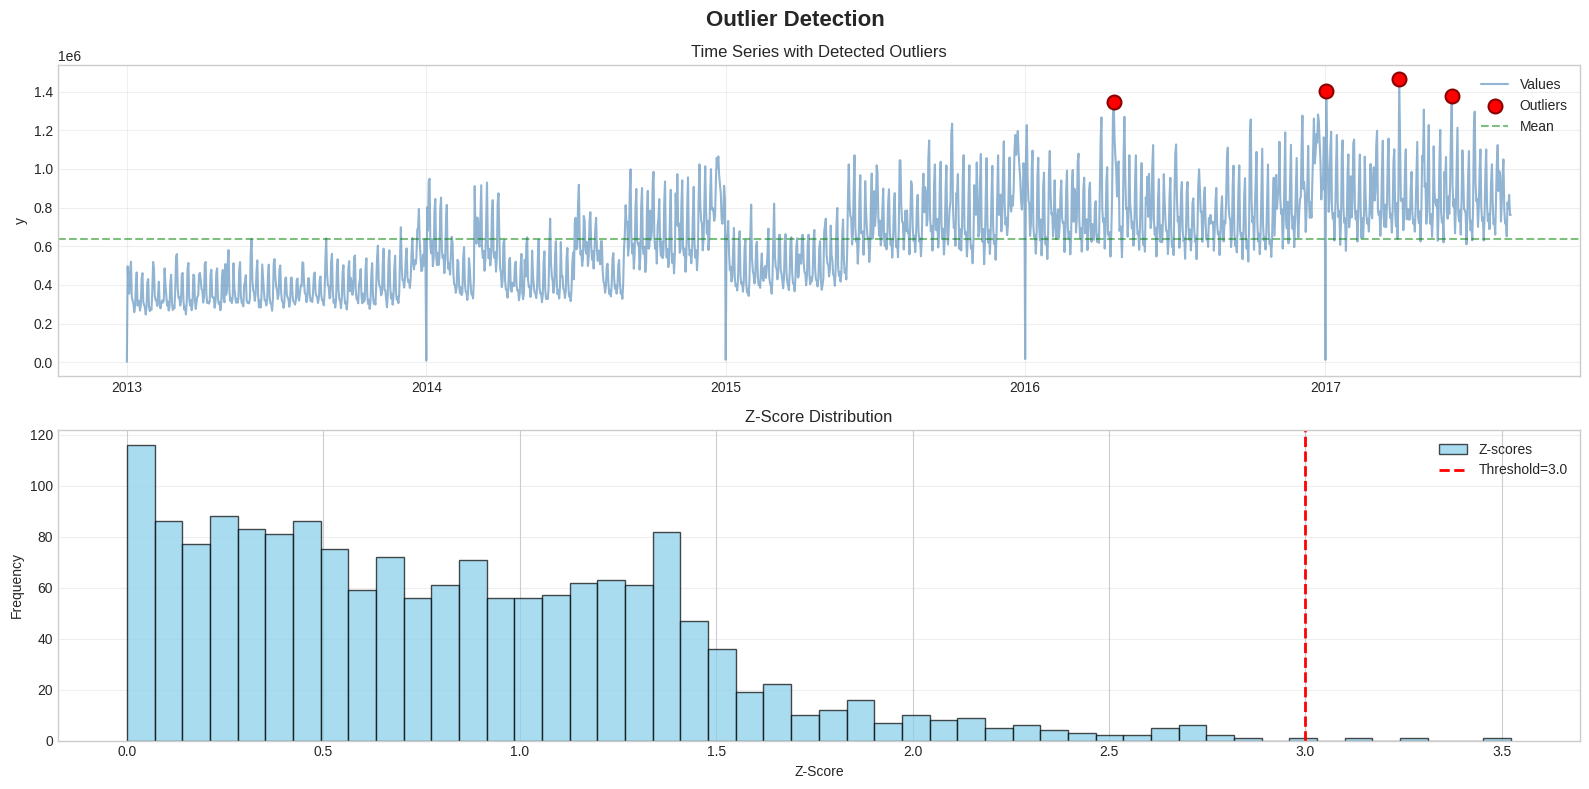

In [ ]:
#@title 7. Outlier Visualization (Z-Score Analysis)

print("\n" + "="*80)
print("OUTLIER ANALYSIS")
print("="*80)

z_scores = np.abs(stats.zscore(y))
outlier_mask = z_scores > config.outlier_threshold
n_outliers = outlier_mask.sum()

print(f"\nZ-Score based outliers (threshold={config.outlier_threshold}):")
print(f"  Detected: {n_outliers} ({n_outliers/len(y)*100:.2f}%)")

if n_outliers > 0:
    outlier_indices = np.where(outlier_mask)[0]
    outlier_dates = dates[outlier_indices]
    outlier_values = y[outlier_indices]
    outlier_z = z_scores[outlier_indices]

    print(f"\n  Top outliers by Z-score:")
    for i in np.argsort(outlier_z)[-min(5, len(outlier_z)):][::-1]:
        print(f"    {outlier_dates[i].date()}: {outlier_values[i]:.2f} (z={outlier_z[i]:.2f})")

# Plot
fig, axes = plt.subplots(2, 1, figsize=(config.fig_width, config.fig_height*0.8))
fig.suptitle('Outlier Detection', fontsize=16, fontweight='bold')

# Time series with outliers highlighted
axes[0].plot(dates, y, color='steelblue', alpha=0.6, linewidth=1.5, label='Values')
if n_outliers > 0:
    axes[0].scatter(dates[outlier_mask], y[outlier_mask],
        color='red', s=100, marker='o', label='Outliers', zorder=5, edgecolors='darkred', linewidth=1.5)
axes[0].axhline(y.mean(), color='green', linestyle='--', alpha=0.5, label='Mean')
axes[0].set_title('Time Series with Detected Outliers')
axes[0].set_ylabel(config.target_column)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Z-score distribution
axes[1].hist(z_scores, bins=50, color='skyblue', edgecolor='black', alpha=0.7, label='Z-scores')
axes[1].axvline(config.outlier_threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold={config.outlier_threshold}')
axes[1].set_title('Z-Score Distribution')
axes[1].set_xlabel('Z-Score')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()
print("="*80)


CHANGEPOINT DETECTION

MAD-based changepoints (window=112, sensitivity=2.0):
  Detected: 28 (1.66%)

  Top changepoints by MAD:
    2016-11-13: 1188982.23 (MAD=160319.96)
    2016-11-12: 929802.77 (MAD=158008.04)
    2016-11-15: 691801.63 (MAD=158008.04)
    2016-11-14: 735723.17 (MAD=158008.04)
    2016-11-11: 713396.45 (MAD=152479.12)


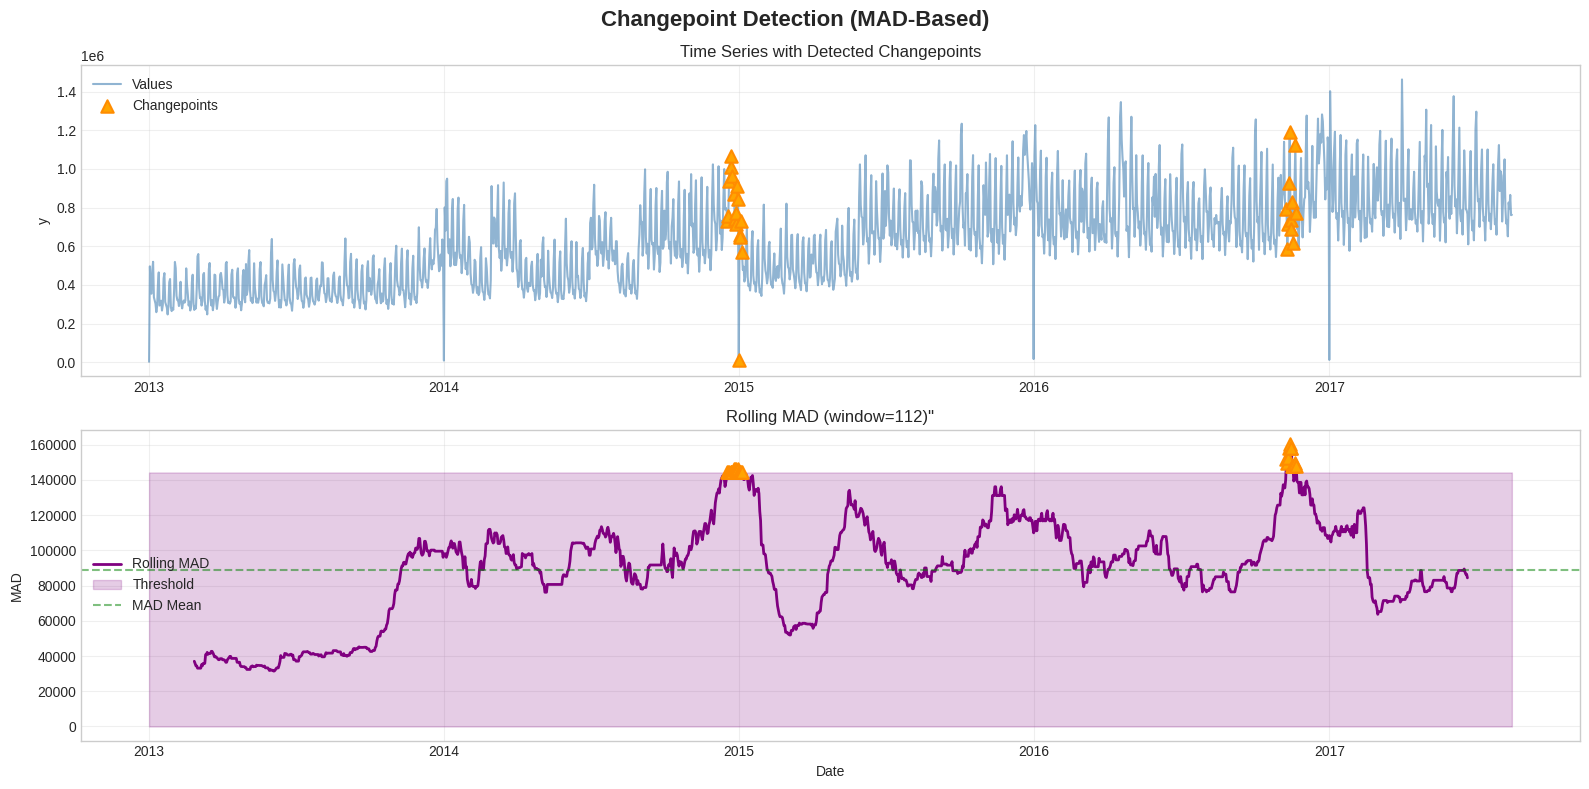

In [ ]:
#@title 8. Changepoint Detection (MAD-Based)

print("\n" + "="*80)
print("CHANGEPOINT DETECTION")
print("="*80)

# Robust changepoint detection using Median Absolute Deviation
window = max(10, len(y) // 15)
rolling_mad = pd.Series(y).rolling(window, center=True).apply(
    lambda x: np.median(np.abs(x - np.median(x))), raw=False
)

mad_mean = rolling_mad.mean()
mad_std = rolling_mad.std()
threshold = mad_mean + config.changepoint_sensitivity * mad_std

changepoint_mask = (rolling_mad > threshold) & (rolling_mad.notna())
n_changepoints = changepoint_mask.sum()

print(f"\nMAD-based changepoints (window={window}, sensitivity={config.changepoint_sensitivity}):")
print(f"  Detected: {n_changepoints} ({n_changepoints/len(y)*100:.2f}%)")

if n_changepoints > 0:
    cp_indices = np.where(changepoint_mask)[0]
    cp_dates = dates[cp_indices]
    cp_values = y[cp_indices]

    print(f"\n  Top changepoints by MAD:")
    for i in np.argsort(rolling_mad[cp_indices])[-min(5, len(cp_indices)):][::-1]:
        print(f"    {cp_dates[i].date()}: {cp_values[i]:.2f} (MAD={rolling_mad.iloc[cp_indices[i]]:.2f})")

# Plot
fig, axes = plt.subplots(2, 1, figsize=(config.fig_width, config.fig_height*0.8))
fig.suptitle('Changepoint Detection (MAD-Based)', fontsize=16, fontweight='bold')

# Time series with changepoints
axes[0].plot(dates, y, color='steelblue', alpha=0.6, linewidth=1.5, label='Values')
if n_changepoints > 0:
    axes[0].scatter(dates[changepoint_mask], y[changepoint_mask],
        color='orange', s=80, marker='^', label='Changepoints', zorder=5, edgecolors='darkorange', linewidth=1.5)
axes[0].set_title('Time Series with Detected Changepoints')
axes[0].set_ylabel(config.target_column)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAD analysis
axes[1].plot(dates, rolling_mad, color='purple', linewidth=2, label='Rolling MAD')
axes[1].fill_between(dates, 0, threshold, alpha=0.2, color='purple', label='Threshold')
axes[1].axhline(mad_mean, color='green', linestyle='--', alpha=0.5, label='MAD Mean')
if n_changepoints > 0:
    axes[1].scatter(dates[changepoint_mask], rolling_mad[changepoint_mask],
        color='orange', s=80, marker='^', zorder=5, edgecolors='darkorange', linewidth=1.5)
axes[1].set_title(f'Rolling MAD (window={window})"')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('MAD')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
print("="*80)

In [ ]:
#@title 9. Statistical Tests

print("\n" + "="*80)
print("STATISTICAL ANALYSIS")
print("="*80)

# Distribution
skew = stats.skew(y)
kurt = stats.kurtosis(y)
print(f"\nDistribution:")
print(f"  Skewness: {skew:.4f} {'(symmetric)' if abs(skew)<0.5 else '(skewed)'}")
print(f"  Kurtosis: {kurt:.4f} {'(normal tails)' if abs(kurt)<0.5 else '(heavy tails)'}")

# Normality
try:
    shapiro_stat, shapiro_p = stats.shapiro(y[:min(5000, len(y))])
    print(f"\nNormality (Shapiro-Wilk):")
    print(f"  p-value: {shapiro_p:.6f}")
    print(f"  Result: {'Normal (p>0.05)' if shapiro_p > 0.05 else 'Non-normal (p≤0.05)'}")
except Exception as e:
    print(f"\nNormality test: Could not compute ({e})")

# Stationarity (ADF)
try:
    adf_result = adfuller(y, autolag='AIC')
    print(f"\nStationarity (ADF):")
    print(f"  p-value: {adf_result[1]:.6f}")
    print(f"  Result: {'STATIONARY (p≤0.05)' if adf_result[1] <= 0.05 else 'NON-STATIONARY (p>0.05)'}")
except Exception as e:
    print(f"\nADF test: Could not compute ({e})")

# Stationarity (KPSS)
try:
    kpss_stat, kpss_p, _, _ = kpss(y, regression='c', nlags='auto')
    print(f"\nStationarity (KPSS):")
    print(f"  p-value: {kpss_p:.6f}")
    print(f"  Result: {'STATIONARY (p>0.05)' if kpss_p > 0.05 else 'NON-STATIONARY (p≤0.05)'}")
except Exception as e:
    print(f"\nKPSS test: Could not compute ({e})")

print("="*80)


STATISTICAL ANALYSIS

Distribution:
  Skewness: 0.4135 (symmetric)
  Kurtosis: -0.2639 (normal tails)

Normality (Shapiro-Wilk):
  p-value: 0.000000
  Result: Non-normal (p≤0.05)

Stationarity (ADF):
  p-value: 0.089696
  Result: NON-STATIONARY (p>0.05)

Stationarity (KPSS):
  p-value: 0.010000
  Result: NON-STATIONARY (p≤0.05)


In [ ]:
#@title 10. EDA Visualization

if config.viz_style == VisualizationStyle.PLOTLY:
    fig = make_subplots(rows=2, cols=2,
        subplot_titles=('Time Series', 'Distribution', 'Box Plot', 'Q-Q Plot'),
        specs=[[{"type": "scatter"}, {"type": "histogram"}],
               [{"type": "box"}, {"type": "scatter"}]])

    # Time series
    window = max(7, len(y)//20)
    rolling = pd.Series(y).rolling(window, center=True).mean()
    fig.add_trace(go.Scatter(x=dates, y=y, mode='lines', name='Data',
        line=dict(color='steelblue', width=1.5)), row=1, col=1)
    fig.add_trace(go.Scatter(x=dates, y=rolling, mode='lines', name=f'MA({window})',
        line=dict(color='red', width=2)), row=1, col=1)

    # Histogram
    fig.add_trace(go.Histogram(x=y, nbinsx=50, name='Dist',
        marker=dict(color='coral')), row=1, col=2)

    # Box plot
    fig.add_trace(go.Box(y=y, name='Box', marker=dict(color='lightblue'),
        boxmean='sd'), row=2, col=1)

    # Q-Q plot
    qq = stats.probplot(y, dist="norm")
    fig.add_trace(go.Scatter(x=qq[0][0], y=qq[0][1], mode='markers',
        name='Q-Q', marker=dict(size=4)), row=2, col=2)
    fig.add_trace(go.Scatter(x=qq[0][0], y=qq[0][0], mode='lines',
        line=dict(color='red', dash='dash')), row=2, col=2)

    fig.update_layout(height=700, showlegend=False, title_text="EDA Dashboard")
    fig.show()

else:
    fig, axes = plt.subplots(2, 2, figsize=(config.fig_width, config.fig_height))
    fig.suptitle('EDA Dashboard', fontsize=16, fontweight='bold')

    # Time series
    window = max(7, len(y)//20)
    rolling = pd.Series(y).rolling(window, center=True).mean()
    axes[0,0].plot(dates, y, alpha=0.7, label='Data')
    axes[0,0].plot(dates, rolling, color='red', linewidth=2, label=f'MA({window})')
    axes[0,0].set_title('Time Series')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # Distribution
    axes[0,1].hist(y, bins=50, edgecolor='black', alpha=0.7, color='coral', density=True)
    kde = gaussian_kde(y)
    x_range = np.linspace(y.min(), y.max(), 100)
    axes[0,1].plot(x_range, kde(x_range), 'k-', linewidth=2)
    axes[0,1].set_title('Distribution')
    axes[0,1].grid(True, alpha=0.3)

    # Box plot
    axes[1,0].boxplot(y, vert=True, patch_artist=True,
        boxprops=dict(facecolor='lightblue'),
        medianprops=dict(color='red', linewidth=2))
    axes[1,0].set_title('Box Plot')
    axes[1,0].grid(True, alpha=0.3, axis='y')

    # Q-Q plot
    stats.probplot(y, dist="norm", plot=axes[1,1])
    axes[1,1].set_title('Q-Q Plot')
    axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

print("EDA complete")

EDA complete



ADVANCED ANALYSIS


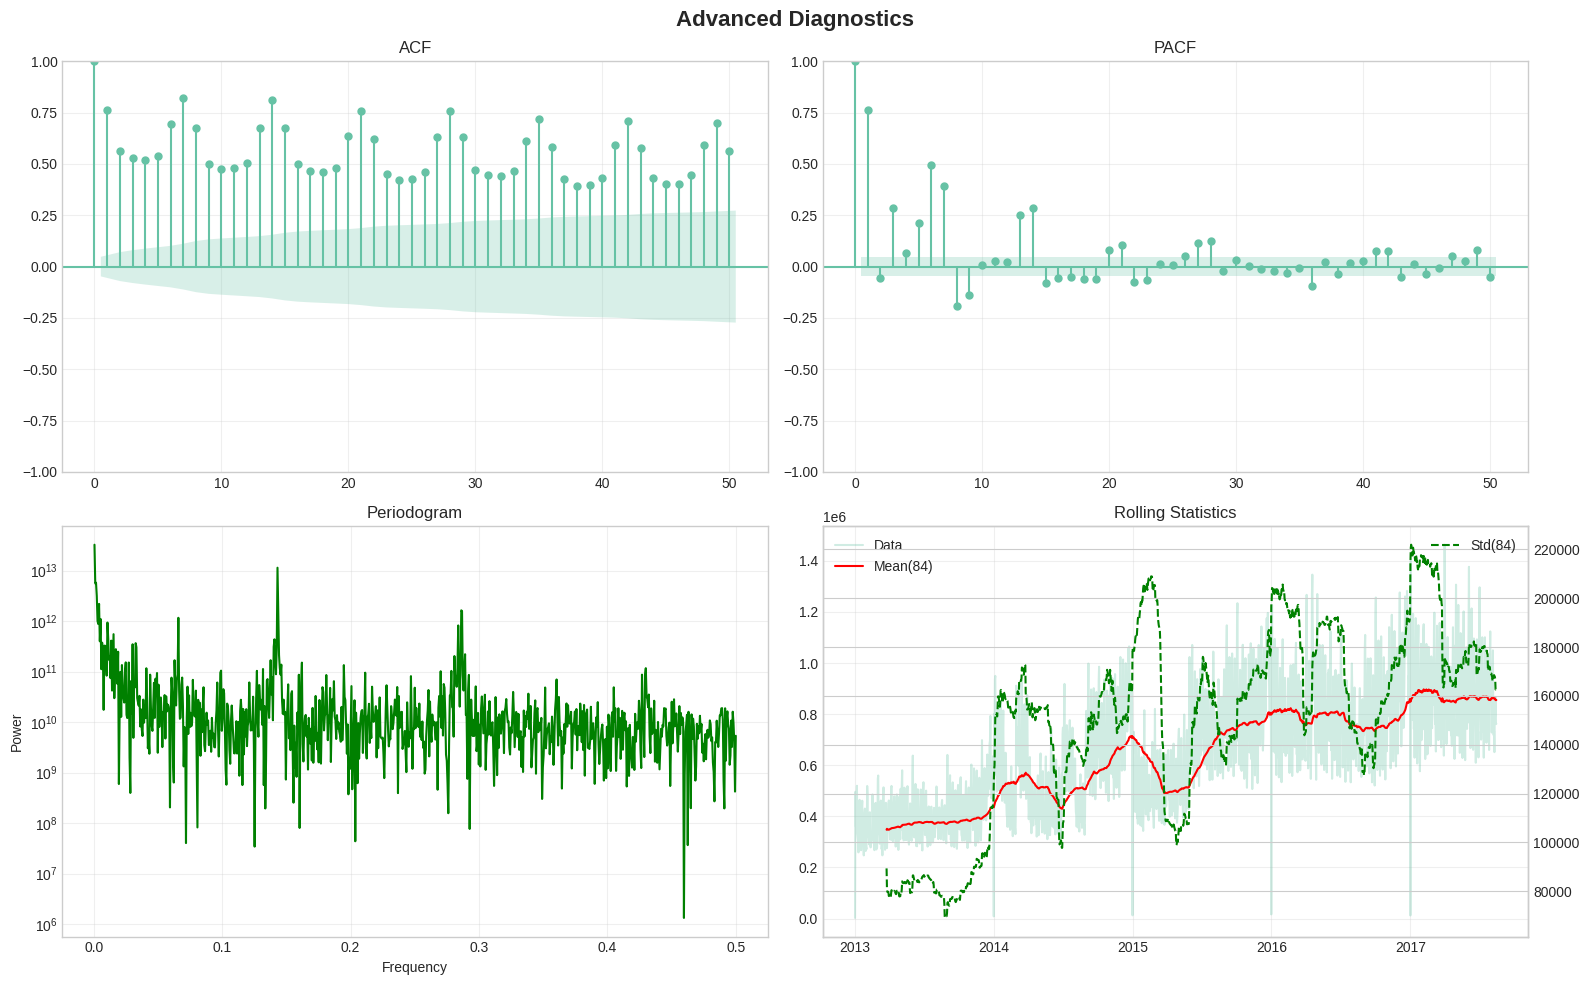

Advanced EDA complete


In [ ]:
#@title 11. Advanced EDA (ACF/PACF/Periodogram)

if show_advanced:
    print("\n" + "="*80)
    print("ADVANCED ANALYSIS")
    print("="*80)

    fig, axes = plt.subplots(2, 2, figsize=(config.fig_width, config.fig_height))
    fig.suptitle('Advanced Diagnostics', fontsize=16, fontweight='bold')

    max_lags = min(50, len(y)//2 - 1)

    # ACF
    plot_acf(y, lags=max_lags, ax=axes[0,0], alpha=0.05)
    axes[0,0].set_title('ACF')
    axes[0,0].grid(True, alpha=0.3)

    # PACF
    plot_pacf(y, lags=max_lags, ax=axes[0,1], alpha=0.05, method='ywm')
    axes[0,1].set_title('PACF')
    axes[0,1].grid(True, alpha=0.3)

    # Periodogram
    freqs, power = signal.periodogram(y)
    axes[1,0].semilogy(freqs[1:], power[1:], color='green')
    axes[1,0].set_title('Periodogram')
    axes[1,0].set_xlabel('Frequency')
    axes[1,0].set_ylabel('Power')
    axes[1,0].grid(True, alpha=0.3)

    # Rolling statistics
    window = max(12, len(y)//20)
    rolling_mean = pd.Series(y).rolling(window).mean()
    rolling_std = pd.Series(y).rolling(window).std()
    axes[1,1].plot(dates, y, alpha=0.3, label='Data')
    axes[1,1].plot(dates, rolling_mean, color='red', label=f'Mean({window})')
    ax_twin = axes[1,1].twinx()
    ax_twin.plot(dates, rolling_std, color='green', linestyle='--', label=f'Std({window})')
    axes[1,1].set_title('Rolling Statistics')
    axes[1,1].legend(loc='upper left')
    ax_twin.legend(loc='upper right')
    axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    print("Advanced EDA complete")
    print("="*80)

In [ ]:
#@title 12. AutoMFLES System Class

class AutoMFLESSystem:
    """Enterprise AutoMFLES forecasting system"""

    FREQ_MAP = {
        'D': FrequencyMetadata('Daily', 365, [7, 30, 365]),
        'H': FrequencyMetadata('Hourly', 8760, [24, 168, 8760]),
        'M': FrequencyMetadata('Monthly', 12, [3, 4, 6, 12]),
        'W': FrequencyMetadata('Weekly', 52, [4, 13, 52]),
        'Q': FrequencyMetadata('Quarterly', 4, [4]),
        'B': FrequencyMetadata('Business Daily', 252, [5, 20, 252]),
    }

    def __init__(self, config: ModelConfiguration) -> None:
        self.config = config
        self.model = None
        self.fitted_values = None
        self.freq_code = None
        self.freq_meta = None
        self.seasonalities: List[SeasonalityInfo] = []
        self.horizon = 0

    def infer_frequency(self, dates: pd.DatetimeIndex) -> Tuple[str, FrequencyMetadata]:
        """Infer frequency from dates"""
        try:
            inferred = pd.infer_freq(dates)
            if inferred:
                base = inferred.strip('0123456789-')
                if base in self.FREQ_MAP:
                    return base, self.FREQ_MAP[base]
        except:
            pass

        # Fallback
        diffs = np.diff(dates.values).astype('timedelta64[s]').astype(int)
        median = int(np.median(diffs))

        if median < 3600:
            return 'H', self.FREQ_MAP['H']
        elif median < 86400:
            return 'H', self.FREQ_MAP['H']
        elif median < 604800:
            return 'D', self.FREQ_MAP['D']
        elif median < 2678400:
            return 'W', self.FREQ_MAP['W']
        else:
            return 'M', self.FREQ_MAP['M']

    def detect_seasonality(self, y: np.ndarray, freq_meta: FrequencyMetadata) -> Optional[List[int]]:
        """Detect seasonal periods via FFT"""
        common = freq_meta.common_seasons
        if not common:
            return None

        n = len(y)
        valid = [s for s in common if s < n // 4]
        if not valid:
            return [min(12, max(4, n // 5))]

        try:
            detrended = signal.detrend(y)
            power = np.abs(fft(detrended))**2
            power_norm = power / np.max(power)
            freqs = np.fft.fftfreq(n)

            strengths = {}
            for s in valid:
                idx = np.argmin(np.abs(freqs - 1.0/s))
                window = max(1, min(5, len(freqs)//100))
                strengths[s] = float(np.mean(power_norm[max(1, idx-window):min(len(power), idx+window+1)]))

            significant = {s: p for s, p in strengths.items() if p >= self.config.seasonality_threshold}
            if not significant:
                return None

            ranked = sorted(significant.keys(), key=lambda x: significant[x], reverse=True)
            selected = ranked[:self.config.max_seasonalities]

            self.seasonalities = [SeasonalityInfo(s, significant[s], i+1) for i, s in enumerate(selected)]

            if self.config.verbose:
                print(f"\nDetected {len(selected)} seasonal patterns:")
                for s in self.seasonalities:
                    print(f"  Rank {s.rank}: Period {s.period} (power={s.power:.4f})")

            return selected
        except Exception as e:
            print(f"Warning: Seasonality detection failed: {e}")
            return None

    def fit(self, y: np.ndarray, dates: pd.DatetimeIndex) -> 'AutoMFLESSystem':
        """Fit the model"""
        n = len(y)

        if self.config.verbose:
            print("\n" + "="*80)
            print("MODEL TRAINING")
            print("="*80)

        # Frequency
        self.freq_code, self.freq_meta = self.infer_frequency(dates)
        print(f"Frequency: {self.freq_meta.name}")

        # Horizon
        self.horizon = max(1, int(n * self.config.forecast_horizon_pct))

        # Seasonality
        if self.config.auto_detect_seasonality:
            season_length = self.detect_seasonality(y, self.freq_meta)
        else:
            season_length = self.config.manual_seasonal_periods

        test_size = min(min(season_length) if season_length else n//10, max(1, n//5))

        # Model config
        model_config = {
            'seasonality_weights': [True, False],
            'smoother': [True, False],
            'ma': [3, 4, None],
            'seasonal_period': [None, season_length] if season_length else [None],
        }

        print(f"Seasonal periods: {season_length}")
        print(f"CV: {self.config.n_cv_windows} windows x {test_size} periods")
        print(f"Metric: {self.config.metric.value.upper()}")

        try:
            self.model = AutoMFLES(
                season_length=season_length,
                test_size=test_size,
                n_windows=self.config.n_cv_windows,
                metric=self.config.metric.value,
                config=model_config,
                prediction_intervals=ConformalIntervals(h=self.horizon),
                verbose=False
            )

            self.model.fit(y=y)
            self.fitted_values = self.model.predict_in_sample()['fitted']
            print("Training: COMPLETE")
        except Exception as e:
            print(f"Error: Model training failed: {e}")
            raise

        if self.config.verbose:
            print("="*80)

        return self

    def predict(self, h: Optional[int] = None, level: Optional[List[int]] = None) -> Dict[str, Any]:
        """Generate forecasts"""
        if h is None:
            h = self.horizon
        if level is None:
            level = self.config.confidence_levels
        return self.model.predict(h=h, level=level)

print("AutoMFLES System: LOADED")

AutoMFLES System: LOADED


In [ ]:
#@title 13. Train Model

forecaster = AutoMFLESSystem(config)
forecaster.fit(y, dates)


MODEL TRAINING
Frequency: Daily

Detected 2 seasonal patterns:
  Rank 1: Period 7 (power=0.1182)
  Rank 2: Period 365 (power=0.0596)
Seasonal periods: [7, 365]
CV: 3 windows x 7 periods
Metric: SMAPE
Training: COMPLETE



DECOMPOSITION
MSTL with periods: [7, 365]
  Inspecting MSTL seasonal components (n=2, type=ndarray):
    Component 'Period 7' raw values (first 10): [-157172.98051198   32152.76734311  -69947.37428858  -44024.42039431
  172834.8750082   131938.17936142  -72643.51688474 -134064.62049389
   16497.90320094  -68238.81975785]
    Component 'Period 7' type: <class 'numpy.ndarray'>
    Component 'Period 7' length: 1684
    Are all values NaN in Period 7? False
    Number of non-NaN values in Period 7: 1684
    Component 'Period 7' statistics after NaN removal:
      Min: -211111.5267, Max: 301346.1522
      Mean: -15.7630, Std: 112428.2276
--------------------
    Component 'Period 365' raw values (first 10): [ 18265.78483771 174076.00547303 179729.81104271 129678.43680574
 -18925.23131585 102171.79135514 138608.66065501 102996.66446866
  19360.35634984  41611.92239646]
    Component 'Period 365' type: <class 'numpy.ndarray'>
    Component 'Period 365' length: 1684
    Are all values NaN in 

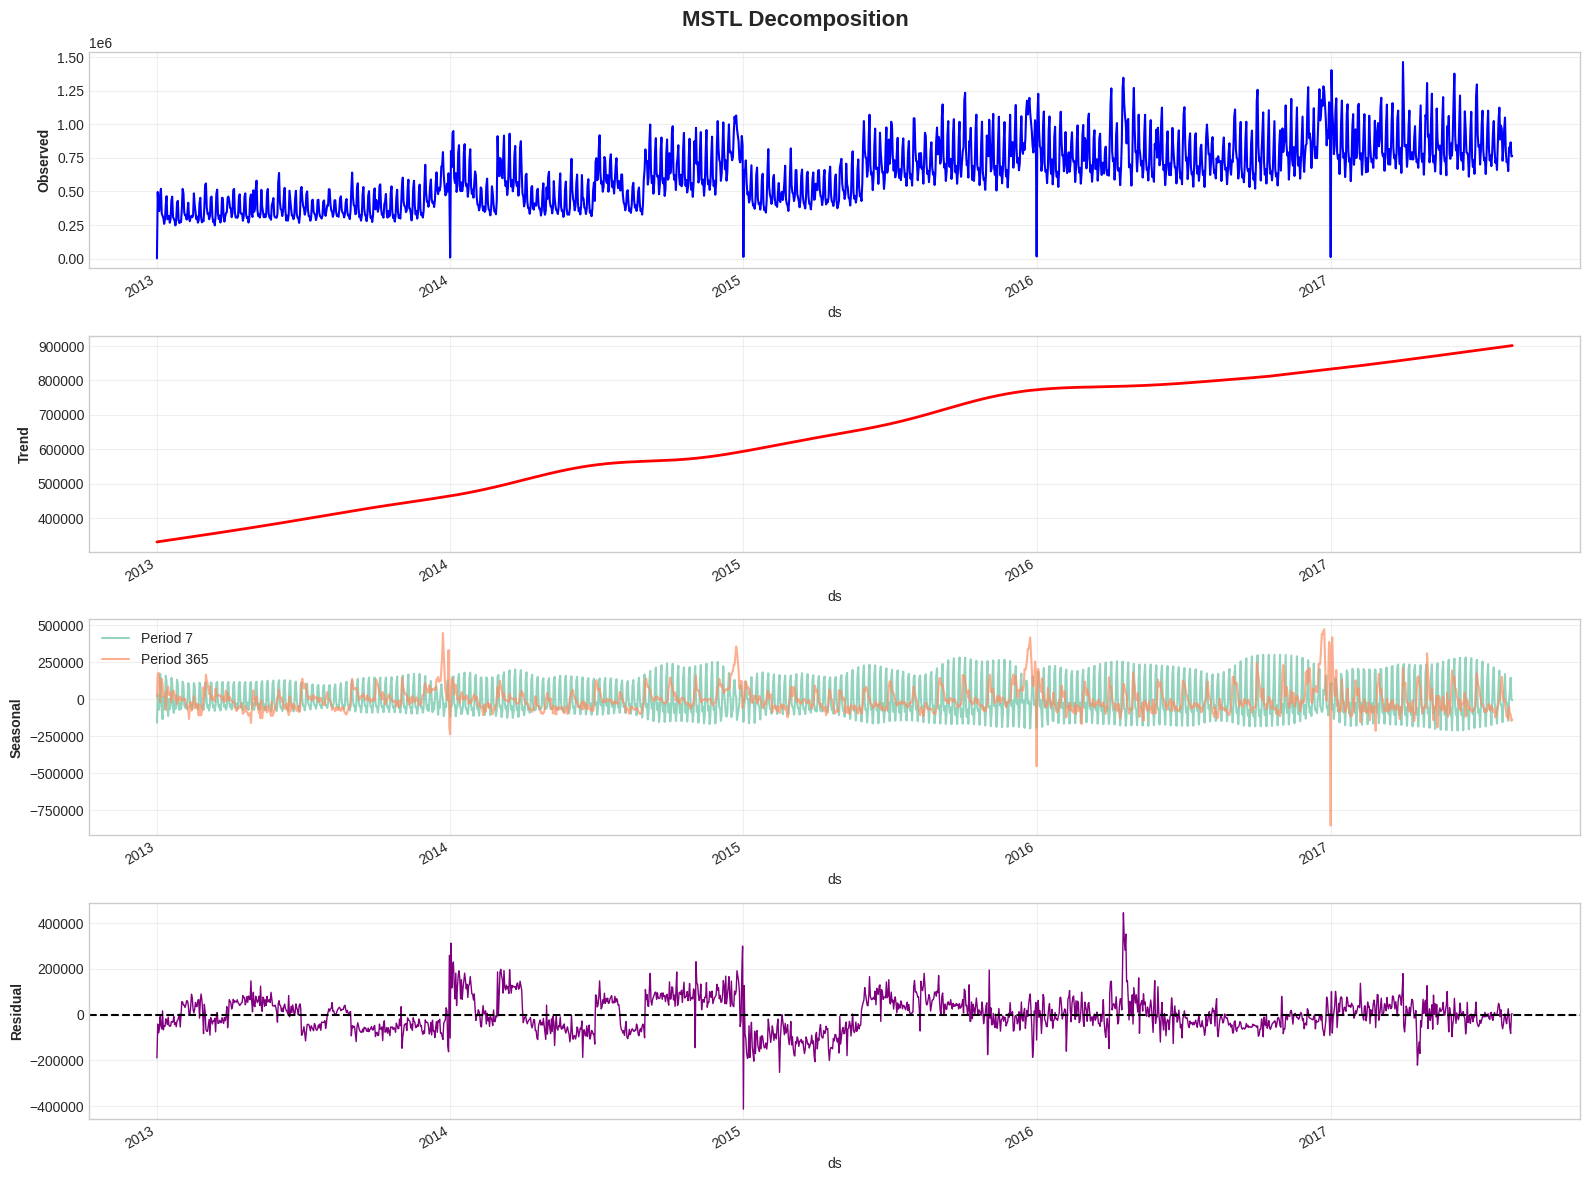

✓ MSTL complete for 2 patterns


In [ ]:
# @title Time Series decomposition

if forecaster.seasonalities and len(y) >= 24:
    print("\n" + "="*80)
    print("DECOMPOSITION")
    print("="*80)

    try:
        if len(forecaster.seasonalities) > 1:
            periods = [s.period for s in forecaster.seasonalities[:2]]
            print(f"MSTL with periods: {periods}")

            mstl = MSTL(y, periods=periods)
            result = mstl.fit()

            fig, axes = plt.subplots(4, 1, figsize=(config.fig_width, config.fig_height+2))
            fig.suptitle('MSTL Decomposition', fontsize=16, fontweight='bold')

            pd.Series(result.observed, index=dates).plot(ax=axes[0], color='blue', linewidth=1.5)
            axes[0].set_ylabel('Observed', fontweight='bold')
            axes[0].grid(True, alpha=0.3)

            pd.Series(result.trend, index=dates).plot(ax=axes[1], color='red', linewidth=2)
            axes[1].set_ylabel('Trend', fontweight='bold')
            axes[1].grid(True, alpha=0.3)

            # Refactored part for MSTL seasonal components
            all_seasonal_values = []

            # Check if seasonal is a numpy array (common for multiple seasonalities in newer statsmodels)
            if isinstance(result.seasonal, np.ndarray) and result.seasonal.ndim == 2:
                print(f"  Inspecting MSTL seasonal components (n={result.seasonal.shape[1]}, type=ndarray):")
                for i in range(result.seasonal.shape[1]):
                    seasonal_comp = result.seasonal[:, i]
                    period_label = f"Period {periods[i]}" if i < len(periods) else f"Seasonal Component {i+1}"

                    print(f"    Component '{period_label}' raw values (first 10): {seasonal_comp[:10]}")
                    print(f"    Component '{period_label}' type: {type(seasonal_comp)}")
                    print(f"    Component '{period_label}' length: {len(seasonal_comp)}")
                    print(f"    Are all values NaN in {period_label}? {np.all(np.isnan(seasonal_comp))}")
                    print(f"    Number of non-NaN values in {period_label}: {np.sum(~np.isnan(seasonal_comp))}")

                    non_nan_values = seasonal_comp[~np.isnan(seasonal_comp)]
                    if non_nan_values.size > 0:
                        all_seasonal_values.extend(non_nan_values.tolist())
                        print(f"    Component '{period_label}' statistics after NaN removal:")
                        print(f"      Min: {np.min(non_nan_values):.4f}, Max: {np.max(non_nan_values):.4f}")
                        print(f"      Mean: {np.mean(non_nan_values):.4f}, Std: {np.std(non_nan_values):.4f}")
                    else:
                        print(f"      WARNING: {period_label} has no non-NaN values for collection.")
                    print("-" * 20) # Separator for clarity

                    pd.Series(seasonal_comp, index=dates).plot(ax=axes[2], label=period_label, alpha=0.7, linewidth=1.5)

            # Original handling for list/dict/DataFrame (less common for MSTL with multiple periods)
            elif isinstance(result.seasonal, list): # MSTL seasonal is a list of arrays
                print(f"  Inspecting MSTL seasonal components (n={len(result.seasonal)}, type=list):")
                for i, seasonal_comp in enumerate(result.seasonal):
                    period_label = f"Period {periods[i]}" if i < len(periods) else f"Seasonal Component {i+1}"
                    print(f"    Component '{period_label}' raw values (first 10): {seasonal_comp[:10] if isinstance(seasonal_comp, (np.ndarray, pd.Series)) else 'N/A'}")
                    print(f"    Component '{period_label}' type: {type(seasonal_comp)}")
                    print(f"    Component '{period_label}' length: {len(seasonal_comp)}")
                    print(f"    Are all values NaN in {period_label}? {np.all(np.isnan(seasonal_comp)) if isinstance(seasonal_comp, (np.ndarray, pd.Series)) else 'N/A'}")
                    print(f"    Number of non-NaN values in {period_label}: {np.sum(~np.isnan(seasonal_comp)) if isinstance(seasonal_comp, (np.ndarray, pd.Series)) else 'N/A'}")

                    if isinstance(seasonal_comp, np.ndarray):
                        non_nan_values = seasonal_comp[~np.isnan(seasonal_comp)]
                        if non_nan_values.size > 0:
                            all_seasonal_values.extend(non_nan_values.tolist())
                        else:
                            print(f"      WARNING: {period_label} has no non-NaN values for collection.")
                    elif isinstance(seasonal_comp, pd.Series):
                        non_nan_values = seasonal_comp.dropna()
                        if non_nan_values.size > 0:
                            all_seasonal_values.extend(non_nan_values.tolist())
                        else:
                            print(f"      WARNING: {period_label} has no non-NaN values for collection.")
                    else:
                        print(f"      WARNING: Unexpected type for seasonal component: {type(seasonal_comp)}")

                    if isinstance(seasonal_comp, (np.ndarray, pd.Series)) and non_nan_values.size > 0: # Only print stats if there's actual data
                        print(f"    Component '{period_label}' statistics after NaN removal:")
                        print(f"      Min: {np.min(non_nan_values):.4f}, Max: {np.max(non_nan_values):.4f}")
                        print(f"      Mean: {np.mean(non_nan_values):.4f}, Std: {np.std(non_nan_values):.4f}")
                    print("-" * 20) # Separator for clarity

                    pd.Series(seasonal_comp, index=dates).plot(ax=axes[2], label=period_label, alpha=0.7, linewidth=1.5)
            elif isinstance(result.seasonal, dict):
                for period, seasonal_comp in result.seasonal.items():
                    pd.Series(seasonal_comp, index=dates).plot(ax=axes[2], label=f'Period {period}', alpha=0.7, linewidth=1.5)
                    if isinstance(seasonal_comp, np.ndarray):
                        all_seasonal_values.extend(seasonal_comp[~np.isnan(seasonal_comp)].tolist())
                    elif isinstance(seasonal_comp, pd.Series):
                        all_seasonal_values.extend(seasonal_comp.dropna().tolist())
            elif isinstance(result.seasonal, pd.DataFrame):
                for col in result.seasonal.columns:
                    pd.Series(result.seasonal[col], index=dates).plot(ax=axes[2], label=col, alpha=0.7, linewidth=1.5)
                    all_seasonal_values.extend(result.seasonal[col].dropna().tolist())

            axes[2].set_ylabel('Seasonal', fontweight='bold')
            axes[2].legend()
            axes[2].grid(True, alpha=0.3)

            # Explicitly set y-limits for the seasonal plot to ensure visibility
            if all_seasonal_values:
                min_val = np.min(all_seasonal_values)
                max_val = np.max(all_seasonal_values)

                if min_val == max_val:
                    if min_val == 0: # If all zeros, set a small symmetric range
                        axes[2].set_ylim(-0.1, 0.1)
                    else: # If constant non-zero, set a range around it
                        axes[2].set_ylim(min_val - abs(min_val * 0.1), max_val + abs(max_val * 0.1))
                else:
                    # Add a small buffer to min/max for better visualization
                    buffer = (max_val - min_val) * 0.05
                    axes[2].set_ylim(min_val - buffer, max_val + buffer)
            else:
                print("WARNING: all_seasonal_values is empty. Cannot dynamically set y-limits for seasonal plot. Using default range.")
                axes[2].set_ylim(-1, 1) # Set a default small range for visibility

            print(f"Confirm: Length of all_seasonal_values after collection: {len(all_seasonal_values)}")

            pd.Series(result.resid, index=dates).plot(ax=axes[3], color='purple', linewidth=1)
            axes[3].axhline(0, color='black', linestyle='--')
            axes[3].set_ylabel('Residual', fontweight='bold')
            axes[3].grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()
            print(f"✓ MSTL complete for {len(periods)} patterns")

        else:
            period = forecaster.seasonalities[0].period
            if len(y) >= 2 * period:
                print(f"Standard decomposition with period: {period}")
                decomp = seasonal_decompose(y, model='additive', period=period, extrapolate_trend='freq')

                fig, axes = plt.subplots(4, 1, figsize=(config.fig_width, config.fig_height+2))
                fig.suptitle(f'Seasonal Decomposition (Period={period})', fontsize=16, fontweight='bold')

                decomp.observed.plot(ax=axes[0], color='blue', linewidth=1.5)
                axes[0].set_ylabel('Observed', fontweight='bold')
                decomp.trend.plot(ax=axes[1], color='red', linewidth=2)
                axes[1].set_ylabel('Trend', fontweight='bold')
                decomp.seasonal.plot(ax=axes[2], color='green', linewidth=1.5)
                axes[2].set_ylabel('Seasonal', fontweight='bold')
                decomp.resid.plot(ax=axes[3], color='purple', linewidth=1)
                axes[3].axhline(0, color='black', linestyle='--')
                axes[3].set_ylabel('Residual', fontweight='bold')

                for ax in axes:
                    ax.grid(True, alpha=0.3)

                plt.tight_layout()
                plt.show()
                print("✓ Decomposition complete")

    except Exception as e:
        print(f"✗ Decomposition error: {e}")
else:
    print("No seasonality detected - skipping decomposition")

print("="*80)


In [ ]:
#@title 15. Model Diagnostics

print("\n" + "="*80)
print("DIAGNOSTICS")
print("="*80)

residuals = y - forecaster.fitted_values

# Metrics
mae = float(np.mean(np.abs(residuals)))
rmse = float(np.sqrt(np.mean(residuals**2)))
mape = float(np.mean(np.abs(residuals / np.where(y != 0, y, 1))) * 100)
r2 = 1 - (np.sum(residuals**2) / np.sum((y - np.mean(y))**2))
mase = float(mae / np.mean(np.abs(np.diff(y))))

test_lags = min(10, len(residuals)//4)
try:
    lb = acorr_ljungbox(residuals, lags=[test_lags], return_df=True)
    lb_p = float(lb['lb_pvalue'].values[0])
except:
    lb_p = np.nan
    print("Note: Ljung-Box test could not be computed")

metrics = ModelMetrics(mae, rmse, mape, r2, mase, lb_p)

print(f"\nPerformance Metrics:")
print(f"  MAE: {mae:.4f}")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAPE: {mape:.2f}%")
print(f"  R²: {r2:.4f}")
print(f"  MASE: {mase:.4f} {'(better than naive)' if mase < 1 else '(comparable)'}")

if not np.isnan(lb_p):
    print(f"\nLjung-Box p-value: {lb_p:.4f} {'(no autocorr)' if lb_p > 0.05 else '(autocorr detected)'}")

# Add residual statistics
print(f"\nResidual Statistics:")
print(f"  Min: {residuals.min():.2f}")
print(f"  Max: {residuals.max():.2f}")
print(f"  Mean: {residuals.mean():.2f}")
print(f"  Std: {residuals.std():.2f}")

# Visualize diagnostics
if config.viz_style == VisualizationStyle.PLOTLY:
    fig = make_subplots(rows=2, cols=2,
        subplot_titles=('Fitted vs Actual', 'Residuals', 'Residual Dist', 'Q-Q'),
        specs=[[{"type": "scatter"}, {"type": "scatter"}],
               [{"type": "histogram"}, {"type": "scatter"}]])

    fig.add_trace(go.Scatter(x=dates, y=y, mode='lines', name='Actual',
        line=dict(color='blue', width=2)), row=1, col=1)
    fig.add_trace(go.Scatter(x=dates, y=forecaster.fitted_values, mode='lines', name='Fitted',
        line=dict(color='red', width=2, dash='dash')), row=1, col=1)

    fig.add_trace(go.Scatter(x=dates, y=residuals, mode='lines', name='Residuals',
        line=dict(color='purple', width=3)), row=1, col=2) # Increased width

    fig.add_trace(go.Histogram(x=residuals, nbinsx=50, name='Dist',
        marker=dict(color='skyblue')), row=2, col=1)

    qq = stats.probplot(residuals, dist="norm")
    fig.add_trace(go.Scatter(x=qq[0][0], y=qq[0][1], mode='markers',
        name='Q-Q', marker=dict(size=4)), row=2, col=2)
    fig.add_trace(go.Scatter(x=qq[0][0], y=qq[0][0], mode='lines',
        line=dict(color='red', dash='dash')), row=2, col=2)

    fig.update_layout(height=800, showlegend=True, title_text="Diagnostic Dashboard") # Changed to True
    fig.show()

print("="*80)


DIAGNOSTICS

Performance Metrics:
  MAE: 57270.9554
  RMSE: 79202.0328
  MAPE: 10.46%
  R²: 0.8858
  MASE: 0.4924 (better than naive)

Ljung-Box p-value: 0.0000 (autocorr detected)

Residual Statistics:
  Min: -172399.61
  Max: 847303.77
  Mean: 13048.06
  Std: 78119.84


In [ ]:
#@title 16. Generate Forecasts

print("\n" + "="*80)
print("FORECAST GENERATION")
print("="*80)

forecast = forecaster.predict()
h = len(forecast['mean'])
future_dates = pd.date_range(start=dates[-1], periods=h+1, freq=forecaster.freq_code)[1:]

print(f"\nHorizon: {h} periods")
print(f"Confidence: {config.confidence_levels}%")
print(f"Mean forecast: {forecast['mean'].mean():.4f}")
print(f"Range: [{forecast['mean'].min():.4f}, {forecast['mean'].max():.4f}]")

forecast_df = pd.DataFrame({'Date': future_dates, 'Forecast': forecast['mean']})

for level in config.confidence_levels:
    if f'level-{level}-lo' in forecast:
        forecast_df[f'Lower_{level}%'] = forecast[f'level-{level}-lo'].flatten()
        forecast_df[f'Upper_{level}%'] = forecast[f'level-{level}-hi'].flatten()

print(f"\nFirst 10 rows:")
display(forecast_df.head(10))
print("="*80)


FORECAST GENERATION

Horizon: 168 periods
Confidence: [80, 95]%
Mean forecast: 887454.2754
Range: [672889.5028, 1285419.1129]

First 10 rows:


,Date,Forecast
0,2017-08-16,743550.076122
1,2017-08-17,689152.477419
2,2017-08-18,672889.502821
3,2017-08-19,698436.472245
4,2017-08-20,780312.003096
5,2017-08-21,831853.229739
6,2017-08-22,803906.751978
7,2017-08-23,771510.048736
8,2017-08-24,722327.291376
9,2017-08-25,712115.497341


In [ ]:
#@title 17. Forecast Visualization

if config.viz_style == VisualizationStyle.PLOTLY:
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=dates, y=y, mode='lines', name='Historical',
        line=dict(color='steelblue', width=2)))

    fig.add_trace(go.Scatter(x=future_dates, y=forecast['mean'], mode='lines', name='Forecast',
        line=dict(color='red', width=3, dash='dash')))

    colors = ['rgba(255,0,0,0.15)', 'rgba(255,0,0,0.25)']
    for i, level in enumerate(sorted(config.confidence_levels, reverse=True)):
        if f'level-{level}-lo' in forecast:
            fig.add_trace(go.Scatter(x=future_dates, y=forecast[f'level-{level}-hi'].flatten(),
                mode='lines', line=dict(width=0), showlegend=False, hoverinfo='skip'))
            fig.add_trace(go.Scatter(x=future_dates, y=forecast[f'level-{level}-lo'].flatten(),
                mode='lines', line=dict(width=0), fill='tonexty',
                fillcolor=colors[i] if i < len(colors) else 'rgba(255,0,0,0.1)',
                name=f'{level}% CI', hoverinfo='skip'))

    season_info = f"{len(forecaster.seasonalities)} Patterns" if forecaster.seasonalities else "No Seasonality"

    fig.update_layout(
        title=f"Forecast: {forecaster.freq_meta.name} Data - {season_info}",
        xaxis_title='Date',
        yaxis_title=config.target_column,
        hovermode='x unified',
        height=650,
        template='plotly_white',
        xaxis=dict(
            rangeslider=dict(visible=True, thickness=0.05),
            rangeselector=dict(buttons=[
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(step="all", label="All")
            ])
        )
    )
    fig.show()

else:
    fig, ax = plt.subplots(figsize=(config.fig_width, int(config.fig_height*0.8)))

    ax.plot(dates, y, label='Historical', linewidth=2, color='steelblue')
    ax.plot(future_dates, forecast['mean'], label='Forecast',
        linestyle='--', linewidth=2.5, color='red')

    alphas = [0.15, 0.25]
    for i, level in enumerate(sorted(config.confidence_levels, reverse=True)):
        if f'level-{level}-lo' in forecast:
            ax.fill_between(future_dates,
                forecast[f'level-{level}-lo'].flatten(),
                forecast[f'level-{level}-hi'].flatten(),
                alpha=alphas[i] if i < len(alphas) else 0.1,
                color='red', label=f'{level}% CI')

    ax.axvline(dates[-1], color='gray', linestyle=':', linewidth=1.5)

    season_info = f"{len(forecaster.seasonalities)} Patterns" if forecaster.seasonalities else "No Seasonality"
    ax.set_title(f"Forecast: {forecaster.freq_meta.name} Data - {season_info}",
        fontsize=16, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel(config.target_column, fontsize=12)
    ax.legend(loc='best', fontsize=11)
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

print("Visualization complete")

Visualization complete


In [ ]:
#@title 18. Export Results

export_format: str = "Excel" #@param ["CSV", "Excel"]

metadata_df = pd.DataFrame([
    {'Parameter': 'Model', 'Value': 'AutoMFLES'},
    {'Parameter': 'Frequency', 'Value': forecaster.freq_meta.name},
    {'Parameter': 'Seasonal Periods', 'Value': str([s.period for s in forecaster.seasonalities])},
    {'Parameter': 'Observations', 'Value': str(len(y))},
    {'Parameter': 'Forecast Horizon', 'Value': str(h)},
    {'Parameter': 'Metric', 'Value': config.metric.value.upper()},
    {'Parameter': 'CV Windows', 'Value': str(config.n_cv_windows)},
    {'Parameter': 'MAE', 'Value': f"{metrics.mae:.6f}"},
    {'Parameter': 'RMSE', 'Value': f"{metrics.rmse:.6f}"},
    {'Parameter': 'MAPE', 'Value': f"{metrics.mape:.2f}%"},
    {'Parameter': 'R²', 'Value': f"{metrics.r2:.6f}"},
    {'Parameter': 'MASE', 'Value': f"{metrics.mase:.6f}"},
])

try:
    if export_format == "CSV":
        forecast_df.to_csv('forecast_results.csv', index=False)
        metadata_df.to_csv('metadata.csv', index=False)
        if IS_COLAB:
            files.download('forecast_results.csv')
            files.download('metadata.csv')
        print("✓ Exported: CSV files")
    else:
        with pd.ExcelWriter('forecast_results.xlsx', engine='openpyxl') as writer:
            forecast_df.to_excel(writer, sheet_name='Forecast', index=False)
            metadata_df.to_excel(writer, sheet_name='Metadata', index=False)
            pd.DataFrame({
                'Date': dates, 'Actual': y, 'Fitted': forecaster.fitted_values
            }).to_excel(writer, sheet_name='Historical_Fit', index=False)
        if IS_COLAB:
            files.download('forecast_results.xlsx')
        print("✓ Exported: Excel file (3 sheets)")
except Exception as e:
    print(f"✗ Export error: {e}")

In [ ]:
#@title 19. Executive Summary

print("\n" + "="*80)
print("EXECUTIVE SUMMARY")
print("="*80)

print(f"\nData Summary:")
print(f"  Frequency: {forecaster.freq_meta.name}")
print(f"  Observations: {len(y):,}")
print(f"  Range: {dates.min().date()} to {dates.max().date()}")
print(f"  Quality: {quality.missing_pct:.1f}% missing, {quality.outlier_pct:.1f}% outliers")

if forecaster.seasonalities:
    print(f"\nSeasonality Detected:")
    for s in forecaster.seasonalities:
        print(f"  Rank {s.rank}: Period {s.period} (Power={s.power:.4f})")
else:
    print(f"\nSeasonality: None detected")

print(f"\nModel Performance:")
print(f"  R²: {metrics.r2:.4f} ", end="")
if metrics.r2 > 0.9:
    print("→ Excellent")
elif metrics.r2 > 0.7:
    print("→ Good")
elif metrics.r2 > 0.5:
    print("→ Moderate")
else:
    print("→ Needs improvement")

print(f"  MAPE: {metrics.mape:.2f}% ", end="")
if metrics.mape < 10:
    print("→ Excellent")
elif metrics.mape < 20:
    print("→ Good")
elif metrics.mape < 50:
    print("→ Acceptable")
else:
    print("→ Poor")

print(f"  MASE: {metrics.mase:.4f}", end="")
if metrics.mase < 1:
    print(" → Better than naive")
else:
    print(" → Comparable to naive")

print(f"\nForecast Summary:")
print(f"  Horizon: {h} periods ({config.forecast_horizon_pct*100:.0f}% of data)")
print(f"  Mean: {forecast['mean'].mean():.4f}")
trend = "Upward" if forecast['mean'][-1] > y[-1] else "Downward" if forecast['mean'][-1] < y[-1] else "Stable"
print(f"  Trend: {trend}")

print(f"\nRecommendations:")
if metrics.r2 > 0.8 and metrics.mase < 1:
    print(f"  ✓ Status: Production-ready")
elif metrics.r2 > 0.6:
    print(f"  ~ Status: Acceptable - monitor predictions")
else:
    print(f"  ⚠ Status: Needs improvement")

if len(forecaster.seasonalities) > 1:
    print(f"  ✓ Multiple seasonal patterns captured")

print("\n" + "="*80)
print("✓ ANALYSIS COMPLETE")
print("="*80)


EXECUTIVE SUMMARY

Data Summary:
  Frequency: Daily
  Observations: 1,684
  Range: 2013-01-01 to 2017-08-15
  Quality: 0.0% missing, 0.2% outliers

Seasonality Detected:
  Rank 1: Period 7 (Power=0.1182)
  Rank 2: Period 365 (Power=0.0596)

Model Performance:
  R²: 0.8858 → Good
  MAPE: 10.46% → Good
  MASE: 0.4924 → Better than naive

Forecast Summary:
  Horizon: 168 periods (10% of data)
  Mean: 887454.2754
  Trend: Upward

Recommendations:
  ✓ Status: Production-ready
  ✓ Multiple seasonal patterns captured

✓ ANALYSIS COMPLETE
